<a href="https://colab.research.google.com/github/narsym/deep-learning-with-tensorflow-2.0/blob/master/Transfer_Learning_TEMPLATE_from_the_book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [0]:
import os
import time
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Getting dataset while loading it from tfds **important** splitting according to our need

In [0]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
'horses_or_humans',
split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
with_info=True,
as_supervised=True)

Plotting some images

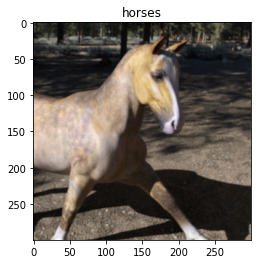

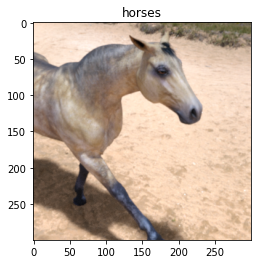

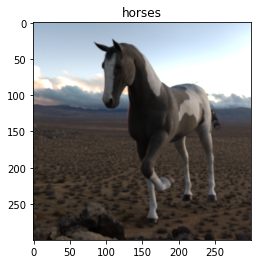

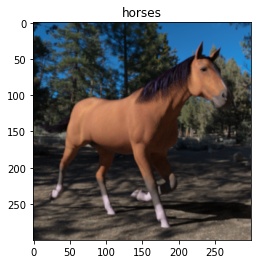

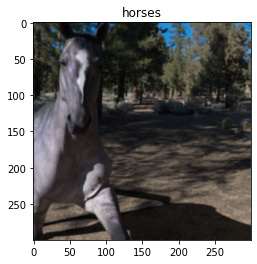

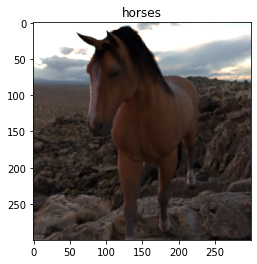

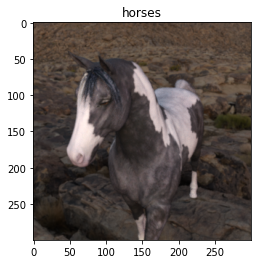

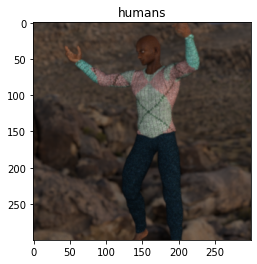

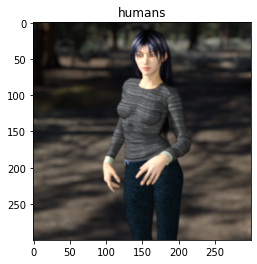

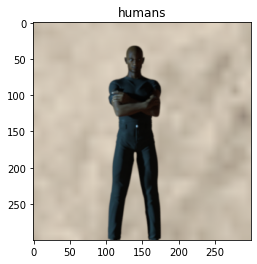

In [9]:
get_label_name = metadata.features['label'].int2str
def show_images(dataset):
  for image, label in dataset.take(10):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
show_images(raw_train)

Formatting images

In [0]:
IMG_SIZE = 160
def format_example(image,label):
  image = tf.cast(image,dtype = tf.float32)
  image = (image / 255) - 1
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
  return image, label
train = raw_train.map(format_example)
test = raw_test.map(format_example)
validation = raw_test.map(format_example)

Shuffling data and converting into batches

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 2000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batch = validation.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batch = test.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

Loading MobileNetV2 for keras appilcations

In [15]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,include_top = False,weights = 'imagenet')
base_model.trainable = False
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
________________

**Important steps while building model**

Check shapes of batches of images

In [16]:
for image_batch, label_batch in train_batches.take(1):
  pass
print(image_batch.shape)

(32, 160, 160, 3)


Checking the shape of output from MobileNetV2

In [18]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


using global average Flattening it

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Adding layers after it for prediction

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


**After checking that there is no error** , **build a sequential model**

In [0]:
model = tf.keras.Sequential([
     base_model,
     global_average_layer,
     prediction_layer
])

Fixing learning rate and compiling model

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),loss = 'binary_crossentropy', metrics = ['accuracy'])

check summary

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


calcualting the number of training, validation, and testing examples, then computing the initial accuracy given by the pretrained MobileNetV2

In [28]:
num_train, num_val, num_test = (
    metadata.splits['train'].num_examples * weight / 10
    for weight in SPLIT_WEIGHTS
)
initial_epochs = 10
steps_per_epochs = round(num_train) //  BATCH_SIZE
validation_steps = 4

loss0, accuracy0 = model.evaluate(validation_batch, steps = validation_steps)

4/4 [==============================] - 1s 301ms/step - loss: 6.5078 - accuracy: 0.3883


Now Training the model 

In [29]:
history = model.fit(train_batches,epochs = initial_epochs, validation_data = validation_batch)

Epoch 1/10
26/26 [==============================] - 16s 617ms/step - loss: 4.8888 - accuracy: 0.4818 - val_loss: 4.6871 - val_accuracy: 0.5049
Epoch 2/10
26/26 [==============================] - 16s 618ms/step - loss: 3.8113 - accuracy: 0.5693 - val_loss: 3.9828 - val_accuracy: 0.5728
Epoch 3/10
26/26 [==============================] - 16s 617ms/step - loss: 2.9277 - accuracy: 0.6472 - val_loss: 3.1479 - val_accuracy: 0.6796
Epoch 4/10
26/26 [==============================] - 16s 619ms/step - loss: 2.3909 - accuracy: 0.7275 - val_loss: 2.6562 - val_accuracy: 0.7087
Epoch 5/10
26/26 [==============================] - 16s 619ms/step - loss: 1.8466 - accuracy: 0.7895 - val_loss: 1.6474 - val_accuracy: 0.7379
Epoch 6/10
26/26 [==============================] - 16s 624ms/step - loss: 1.4277 - accuracy: 0.8260 - val_loss: 1.1817 - val_accuracy: 0.7961
Epoch 7/10
26/26 [==============================] - 16s 617ms/step - loss: 1.0383 - accuracy: 0.8504 - val_loss: 0.9474 - val_accuracy: 0.8641

In [32]:
model.evaluate(test_batch)

4/4 [==============================] - 1s 297ms/step - loss: 0.2935 - accuracy: 0.9320


[0.2934761047363281, 0.9320388436317444]

We get 93% accuracy simply due to google's MobileNetV2.